In [1]:
#@title (Run) Part 1: Define required functions for Data processing

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch import Tensor
import os
import argparse
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def balance_val_split(dataset, train_size=12500):

    try:
        targets = np.array(dataset.targets)
    except:
        targets = []  # create an empty list to store the targets
        for data in dataset.datasets:
            targets += data.targets  # concatenate the targets from each dataset into the list
        targets = np.array(targets)
    #targets = np.array(dataset.datasets.targets)
    train_indices, val_indices = train_test_split(
        np.arange(targets.shape[0]),
        train_size=train_size,
        stratify=targets
    )
    train_dataset = Subset(dataset, indices=train_indices)
    # Get the data from the subset dataset
    subset_data = [train_dataset[idx][0] for idx in range(len(train_dataset))]
    subset_labels = [train_dataset[idx][1] for idx in range(len(train_dataset))]
    # Create a dataset from the list of data and targets
    train_dataset = MyDataset(subset_data, subset_labels)
    
    
    val_dataset = Subset(dataset, indices=val_indices)
    # Get the data from the subset dataset
    subset_data = [val_dataset[idx][0] for idx in range(len(val_dataset))]
    subset_labels = [val_dataset[idx][1] for idx in range(len(val_dataset))]
    # Create a dataset from the list of data and targets
    val_dataset = MyDataset(subset_data, subset_labels)

    return train_dataset, val_dataset


def count_label_frequency(target_train_dataset):
	from collections import Counter
	target_labels = []  # create an empty list to store the labels

	for i in range(len(target_train_dataset)):
			_, label = target_train_dataset[i]  # extract the label for the i-th example in the subset
			target_labels.append(label)  # append the label to the 'subset_labels' list


	return Counter(target_labels)
 


def custom_transform(image: Tensor) -> Tensor:
    import random
    # randomly flip horizontally or vertically with 25% chance
    if random.random() < 0.25:
        image = RandomHorizontalFlip(p=1)(image)
    elif random.random() < 0.5:
        image = RandomVerticalFlip(p=1)(image)
    
    # randomly shift the image by 2 pixels to the left or right with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2], image.shape[-1] - 2), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2], image.shape[-1] + 2), pad_if_needed=False)(image)
        
    # randomly shift the image by 2 pixels to the top or bottom with 25% chance
    if random.random() < 0.25:
        image = RandomCrop((image.shape[-2] - 2, image.shape[-1]), pad_if_needed=False)(image)
    elif random.random() < 0.5:
        image = RandomCrop((image.shape[-2] + 2, image.shape[-1]), pad_if_needed=False)(image)

    return image

In [2]:
#@title (Run) Part 2: Define required functions for Data Training

# Training
def train(trainloader, epoch, batch_size=128, logfile = "train.summary"):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        #inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        if inputs.shape[0] != batch_size:
          print(inputs.shape)
          continue
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(net.parameters(), 10)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 30 == 0:
                print(batch_idx, len(trainloader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(trainloader), 'Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)\n'
                     % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()

def test(testloader, epoch, batch_size=128, logfile = "train.summary", save_modelpath = './DLA'):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0



    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            #inputs, targets = inputs.to(device), targets.to(device)
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 30 == 0:
                print(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    print(len(testloader), 'Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f = open(logfile, "a")
    f.write('Epoch: %d | Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)\n'
                         % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    f.close()
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(save_modelpath):
            os.mkdir(save_modelpath)
        torch.save(state, save_modelpath+'/ckpt.pth')
        best_acc = acc

def draw_training_summary(filepath = 'target_train_DCA-BiLSTM.summary'):
    import matplotlib.pyplot as plt
    import numpy as np

    with open(filepath, 'r') as f:
        results_summary = f.read()

    train_epoch = []
    train_loss = []
    train_acc = []
    test_epoch = []
    test_loss=[]
    test_acc=[]
    for line in results_summary.split("\n"):
        try:
            r_epoch = line.split('|')[0].strip().split(' ')[1]
            r_loss = line.split('|')[1].strip().split(' ')[2].replace('%','')
            r_acc = line.split('|')[2].strip().split(' ')[2].replace('%','')
            if 'Train' in line:
                train_epoch.append(int(r_epoch))
                train_loss.append(float(r_loss))
                train_acc.append(float(r_acc))
            if 'Test' in line:
                test_epoch.append(int(r_epoch))
                test_loss.append(float(r_loss))
                test_acc.append(float(r_acc))
        except:
            print(line)

    # Create a new figure and plot the data
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label='Train')
    plt.plot(test_acc, label='Test')
    plt.axhline(y=np.max(test_acc), color='r', linestyle='--')
    # Add text for the horizontal line
    plt.text(test_epoch[-10], np.max(test_acc)*1.05, np.max(test_acc), color='r', fontsize=10)
    # Customize the plot
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='Test')

    # Customize the plot
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()



    # Display the plot
    plt.show()

In [3]:
#@title (Run) Part 3: Prepare Cifar10 dataset for target and shadow model
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def create_cifar_dataset_torch(batch_size=128, target_train_size = 15000, target_test_size= 15000, shadow_train_size = 15000, shadow_test_size= 15000):

  # Data
  print('==> Preparing data..')


  transform = transforms.Compose([
      transforms.ToTensor()
  ])
  
  cifar_trainset = torchvision.datasets.CIFAR10(
      root='./data', train=True, download=True, transform=transform)


  cifar_testset = torchvision.datasets.CIFAR10(
      root='./data', train=False, download=True, transform=transform)

  cifar_dataset = torch.utils.data.ConcatDataset([cifar_trainset, cifar_testset])


  #target_train_size = int(0.25 * len(cifar_dataset)) # 15000
  remain_size = len(cifar_dataset) - target_train_size
  target_train_dataset, remain_dataset = torch.utils.data.random_split(cifar_dataset, [target_train_size, remain_size])

  #target_test_size = int(0.25 * len(cifar_dataset)) # 15000
  remain_size = len(remain_dataset) - target_test_size
  target_test_dataset, remain_dataset = torch.utils.data.random_split(remain_dataset, [target_test_size, remain_size])

  #target_test_dataset, remain_dataset = balance_val_split(remain_dataset, train_size=target_test_size)


  #shadow_train_size = int(0.25 * len(cifar_dataset)) # 15000
  remain_size = len(remain_dataset) - shadow_train_size
  shadow_train_dataset, shadow_test_dataset = torch.utils.data.random_split(remain_dataset, [shadow_train_size, remain_size])
  #shadow_train_dataset, shadow_test_dataset = balance_val_split(remain_dataset, train_size=shadow_train_size)

  print("Setting target_train_dataset size to ",len(target_train_dataset), count_label_frequency(target_train_dataset))
  print("Setting target_test_dataset size to ",len(target_test_dataset), count_label_frequency(target_test_dataset))
  print("Setting shadow_train_dataset size to ",len(shadow_train_dataset), count_label_frequency(shadow_train_dataset))
  print("Setting shadow_test_dataset size to ",len(shadow_test_dataset), count_label_frequency(shadow_test_dataset))
  #print("Setting testset size to ",len(testset))



  '''
  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])
  '''



  transform_train = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      custom_transform,
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  transform_test = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
  ])

  # apply the data augmentation transformations to the subset
  target_train_dataset.dataset.transform = transform_train
  # Load the transformed subset using a DataLoader
  target_trainloader = DataLoader(target_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


  target_test_dataset.dataset.transform = transform_test
  # Load the transformed subset using a DataLoader
  target_testloader = DataLoader(target_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


  # apply the data augmentation transformations to the subset
  shadow_train_dataset.dataset.transform = transform_train
  # Load the transformed subset using a DataLoader
  shadow_trainloader = DataLoader(shadow_train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)


  shadow_test_dataset.dataset.transform = transform_test
  # Load the transformed subset using a DataLoader
  shadow_testloader = DataLoader(shadow_test_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

  return target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader


## Part 4: Define deep learning methods 

In [4]:
#@title (Run) Part 4.1: Define required functions for ReNet

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Subset, DataLoader
import os
import numpy as np
import argparse

from sklearn.model_selection import train_test_split

#on hopper: pip install --upgrade torch==2.0.0+cu118 torchvision==0.15.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html



# renet with one layer
class ReNet(nn.Module):
	def __init__(self, receptive_filter_size, hidden_size, batch_size, image_patches_height, image_patches_width):

		super(ReNet, self).__init__()

		self.batch_size = batch_size
		self.receptive_filter_size = receptive_filter_size
		self.input_size1 = receptive_filter_size * receptive_filter_size * 3
		self.input_size2 = hidden_size * 2
		self.hidden_size = hidden_size

		# vertical rnns
		self.rnn1 = nn.LSTM(self.input_size1, self.hidden_size, dropout = 0.2)
		self.rnn2 = nn.LSTM(self.input_size1, self.hidden_size, dropout = 0.2)

		# horizontal rnns
		self.rnn3 = nn.LSTM(self.input_size2, self.hidden_size, dropout = 0.2)
		self.rnn4 = nn.LSTM(self.input_size2, self.hidden_size, dropout = 0.2)

		self.initHidden()

		feature_map_dim = int(image_patches_height*image_patches_height*hidden_size*2)
		#self.conv1 = nn.Conv2d(hidden_size*2, 2, 3,padding=1)#[1,640,8,8]->[1,1,8,8]
		#self.UpsamplingBilinear2d=nn.UpsamplingBilinear2d(size=(32,32), scale_factor=None)
		self.dense = nn.Linear(feature_map_dim, 1024) #4096
		self.fc = nn.Linear(1024, 10)

		self.log_softmax = nn.LogSoftmax()

	def initHidden(self):
		self.hidden = (Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda()), Variable(torch.zeros(1, self.batch_size, self.hidden_size)).cuda())


	def get_image_patches(self, X, receptive_filter_size):
		"""
		creates image patches based on the dimension of a receptive filter
		"""
		image_patches = []

		_, X_channel, X_height, X_width= X.size()


		for i in range(0, X_height, receptive_filter_size):
			for j in range(0, X_width, receptive_filter_size):
				X_patch = X[:, :, i: i + receptive_filter_size, j : j + receptive_filter_size]
				image_patches.append(X_patch)

		image_patches_height = (X_height // receptive_filter_size)
		image_patches_width = (X_width // receptive_filter_size)


		image_patches = torch.stack(image_patches)
		image_patches = image_patches.permute(1, 0, 2, 3, 4)
		#print("image_patches: ",image_patches.shape)

		image_patches = image_patches.contiguous().view(-1, image_patches_height, image_patches_height, receptive_filter_size * receptive_filter_size * X_channel)

		return image_patches



	def get_vertical_rnn_inputs(self, image_patches, forward):
		"""
		creates vertical rnn inputs in dimensions 
		(num_patches, batch_size, rnn_input_feature_dim)
		num_patches: image_patches_height * image_patches_width
		"""
		vertical_rnn_inputs = []
		_, image_patches_height, image_patches_width, feature_dim = image_patches.size()

		if forward:
			for i in range(image_patches_height):
				for j in range(image_patches_width):
					vertical_rnn_inputs.append(image_patches[:, j, i, :])

		else:
			for i in range(image_patches_height-1, -1, -1):
				for j in range(image_patches_width-1, -1, -1):
					vertical_rnn_inputs.append(image_patches[:, j, i, :])

		vertical_rnn_inputs = torch.stack(vertical_rnn_inputs)


		return vertical_rnn_inputs



	def get_horizontal_rnn_inputs(self, vertical_feature_map, image_patches_height, image_patches_width, forward):
		"""
		creates vertical rnn inputs in dimensions 
		(num_patches, batch_size, rnn_input_feature_dim)
		num_patches: image_patches_height * image_patches_width
		"""
		horizontal_rnn_inputs = []

		if forward:
			for i in range(image_patches_height):
				for j in range(image_patches_width):
					horizontal_rnn_inputs.append(vertical_feature_map[:, i, j, :])
		else:
			for i in range(image_patches_height-1, -1, -1):
				for j in range(image_patches_width -1, -1, -1):
					horizontal_rnn_inputs.append(vertical_feature_map[:, i, j, :])
		
		horizontal_rnn_inputs = torch.stack(horizontal_rnn_inputs)

		return horizontal_rnn_inputs


	def forward(self, X):

		"""ReNet """

		# divide input input image to image patches
		image_patches = self.get_image_patches(X, self.receptive_filter_size)
		_, image_patches_height, image_patches_width, feature_dim = image_patches.size()

		# process vertical rnn inputs
		vertical_rnn_inputs_fw = self.get_vertical_rnn_inputs(image_patches, forward=True)
		vertical_rnn_inputs_rev = self.get_vertical_rnn_inputs(image_patches, forward=False)
    
		#print("vertical_rnn_inputs_fw: ",vertical_rnn_inputs_fw.shape)
		#print("vertical_rnn_inputs_rev: ",vertical_rnn_inputs_rev.shape)
		# extract vertical hidden states
		vertical_forward_hidden, vertical_forward_cell = self.rnn1(vertical_rnn_inputs_fw, self.hidden)
		vertical_reverse_hidden, vertical_reverse_cell = self.rnn2(vertical_rnn_inputs_rev, self.hidden)

		# create vertical feature map
		vertical_feature_map = torch.cat((vertical_forward_hidden, vertical_reverse_hidden), 2)
		vertical_feature_map =  vertical_feature_map.permute(1, 0, 2)

		# reshape vertical feature map to (batch size, image_patches_height, image_patches_width, hidden_size * 2)
		vertical_feature_map = vertical_feature_map.contiguous().view(-1, image_patches_width, image_patches_height, self.hidden_size * 2)
		vertical_feature_map.permute(0, 2, 1, 3)

		# process horizontal rnn inputs
		horizontal_rnn_inputs_fw = self.get_horizontal_rnn_inputs(vertical_feature_map, image_patches_height, image_patches_width, forward=True)
		horizontal_rnn_inputs_rev = self.get_horizontal_rnn_inputs(vertical_feature_map, image_patches_height, image_patches_width, forward=False)

		#print("horizontal_rnn_inputs_fw1: ",horizontal_rnn_inputs_fw.shape)
		#print("horizontal_rnn_inputs_rev1: ",horizontal_rnn_inputs_rev.shape)
		# extract horizontal hidden states
		horizontal_forward_hidden, horizontal_forward_cell = self.rnn3(horizontal_rnn_inputs_fw, self.hidden)
		horizontal_reverse_hidden, horizontal_reverse_cell = self.rnn4(horizontal_rnn_inputs_rev, self.hidden)

		# create horiztonal feature map[64,1,320]
		#print("horizontal_forward_hidden2: ",horizontal_forward_hidden.shape)
		#print("horizontal_reverse_hidden2: ",horizontal_reverse_hidden.shape)
		horizontal_feature_map = torch.cat((horizontal_forward_hidden, horizontal_reverse_hidden), 2)
		horizontal_feature_map =  horizontal_feature_map.permute(1, 0, 2)

		# flatten[1,64,640]
		output = horizontal_feature_map.contiguous().view(-1, image_patches_height , image_patches_width , self.hidden_size * 2)
		output = output.view(output.size(0), -1)
		#output=output.permute(0,3,1,2)#[1,640,8,8]
		#conv1=self.conv1(output)
		#Upsampling=self.UpsamplingBilinear2d(conv1)
		# dense layer
		output = F.relu(self.dense(output))
		 
		# fully connected layer
		logits = self.fc(output)

		# log softmax
		#logits = self.log_softmax(Upsampling)

		return logits


    


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    s = '%s' % (asMinutes(s))
    return s


'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math
from torch import Tensor
import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)



In [5]:
#@title (Run) Part 4.2: Define required functions for DLA & DLA+RNN

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.level = level
        if level == 1:
            self.root = Root(2*out_channels, out_channels)
            self.left_node = block(in_channels, out_channels, stride=stride)
            self.right_node = block(out_channels, out_channels, stride=1)
        else:
            self.root = Root((level+2)*out_channels, out_channels)
            for i in reversed(range(1, level)):
                subtree = Tree(block, in_channels, out_channels,
                               level=i, stride=stride)
                self.__setattr__('level_%d' % i, subtree)
            self.prev_root = block(in_channels, out_channels, stride=stride)
            self.left_node = block(out_channels, out_channels, stride=1)
            self.right_node = block(out_channels, out_channels, stride=1)

    def forward(self, x):
        xs = [self.prev_root(x)] if self.level > 1 else []
        for i in reversed(range(1, self.level)):
            level_i = self.__getattr__('level_%d' % i)
            x = level_i(x)
            xs.append(x)
        x = self.left_node(x)
        xs.append(x)
        x = self.right_node(x)
        xs.append(x)
        out = self.root(xs)
        return out


class DLA(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=10, enable_RNN='LSTM'):
        super(DLA, self).__init__()
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(4096, num_classes)
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(512, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(512, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(512, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)

        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out

In [6]:
#@title (Run) Part 4.3: Define required functions for VGG

'''VGG11/13/16/19 in Pytorch.'''
import torch
import torch.nn as nn


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name, num_classes=10, enable_RNN='LSTM'):
        super(VGG, self).__init__()
        
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        
        self.features = self._make_layers(cfg[vgg_name])
        
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(512, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(512, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(512, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")


    def forward(self, x):
        out = self.features(x)
        
        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


In [7]:
#@title (Run) Part 4.4: Define required functions for ResNet

'''
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, enable_RNN='LSTM'):
        super(ResNet, self).__init__()
        
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.linear = nn.Linear(512*block.expansion, num_classes)
        
        
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(512*block.expansion, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(512*block.expansion, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(512*block.expansion, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")

        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        
        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [8]:
#@title (Run) Part 4.5: Define required functions for DenseNet


'''DenseNet in PyTorch.'''
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10, enable_RNN='LSTM'):
        super(DenseNet, self).__init__()
        
        
        
        self.enable_RNN = enable_RNN
        if enable_RNN not in ['None', 'LSTM', 'Bi-LSTM']:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")
        
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        #self.linear = nn.Linear(num_planes, num_classes)
        
        
        if enable_RNN == 'None':
          self.linear = nn.Linear(num_planes, num_classes)
        elif enable_RNN == 'LSTM':
          self.rnn = nn.LSTM(num_planes, 1024, dropout = 0.6)
          self.linear = nn.Linear(1024, num_classes)
        elif enable_RNN == 'Bi-LSTM':
          self.rnn = nn.LSTM(num_planes, 2048, 1, dropout = 0.3, batch_first=True, bidirectional=True)
          self.linear = nn.Linear(4096, num_classes)
        else:
          raise Exception("enable_RNN only supports one of ['None', 'LSTM', 'Bi-LSTM']")

        
        

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        #out = out.view(out.size(0), -1)
        #out = self.linear(out)
        
        if self.enable_RNN == 'None':
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        else:
          # add LSTM
          #print(out.shape)
          out = out.view(out.size(0), 1,  -1)
          out,_ = self.rnn(out)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)


## Part 5: Setup Target model for training

### Method 1: ReNet

In [9]:
#@title (Run) Part 5.1.1: Select an architecture for Target model training
from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ReNet
#@markdown * Option 2: DLA
#@markdown * Option 3: DLA-LSTM
#@markdown * Option 4: DLA-BiLSTM


method_name = 'ReNet'  #@param {type:"string"}
save_model_folder = './ReNet_models/'   #@param {type:"string"}
batch_size = 128  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}

if method_name == 'ReNet':
  # Model
  print('==> Building model for ' + method_name)

  receptive_filter_size = 4
  hidden_size = 320
  image_size_w = 32
  image_size_h = 32
  

  net = ReNet(receptive_filter_size, hidden_size, batch_size, image_size_w/receptive_filter_size, image_size_h/receptive_filter_size)
  net.cuda()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
  if load_pretrain_weight:
    try:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        checkpoint = torch.load(save_model_folder+'/ckpt.pth')
        net.load_state_dict(checkpoint['net'])
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch']
    except:
        print('!!! Error: no checkpoint directory found!')
  else:
    print('==> Training model from scratch..')

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.01,
                        momentum=0.9, weight_decay=5e-4)
  #optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

  pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
  print("Total trained parameters: ",pytorch_total_params)


print(net)

==> Building model for ReNet


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==> Training model from scratch..
Total trained parameters:  45364234
ReNet(
  (rnn1): LSTM(48, 320, dropout=0.2)
  (rnn2): LSTM(48, 320, dropout=0.2)
  (rnn3): LSTM(640, 320, dropout=0.2)
  (rnn4): LSTM(640, 320, dropout=0.2)
  (dense): Linear(in_features=40960, out_features=1024, bias=True)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=None)
)


In [11]:
#@title (Run) Part 5.1.2: Setup Target and Shadow datasets for ReNet Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader = create_cifar_dataset_torch(batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_test_size, shadow_train_size = shadow_train_size, shadow_test_size= shadow_test_size)


==> Preparing dataset..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({8: 1573, 5: 1564, 9: 1503, 1: 1499, 3: 1488, 4: 1486, 2: 1481, 6: 1475, 0: 1468, 7: 1463})
Setting target_test_dataset size to  15000 Counter({0: 1560, 9: 1555, 4: 1540, 7: 1509, 3: 1503, 1: 1486, 5: 1469, 8: 1465, 6: 1460, 2: 1453})
Setting shadow_train_dataset size to  15000 Counter({6: 1565, 7: 1540, 2: 1523, 0: 1504, 4: 1501, 8: 1487, 9: 1481, 3: 1475, 1: 1464, 5: 1460})
Setting shadow_test_dataset size to  15000 Counter({1: 1551, 2: 1543, 3: 1534, 5: 1507, 6: 1500, 7: 1488, 8: 1475, 4: 1473, 0: 1468, 9: 1461})


In [12]:
#@title (Run) Part 5.1.3: Start Target model training

max_epoch = 100  #@param {type:"integer"}
train_result_summary = 'target_train_ReNet.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary, save_modelpath = save_model_folder)
    scheduler.step()


Epoch: 0
0 117 Train Loss: 2.303 | Train Acc: 11.719% (15/128)
30 117 Train Loss: 2.300 | Train Acc: 12.147% (482/3968)
60 117 Train Loss: 2.295 | Train Acc: 12.795% (999/7808)
90 117 Train Loss: 2.289 | Train Acc: 14.363% (1673/11648)
117 Epoch: 0 | Train Loss: 2.279 | Train Acc: 15.331% (2296/14976)
0 117 Test Loss: 2.198 | Test Acc: 24.219% (31/128)
30 117 Test Loss: 2.219 | Test Acc: 20.010% (794/3968)
60 117 Test Loss: 2.218 | Test Acc: 21.119% (1649/7808)
90 117 Test Loss: 2.218 | Test Acc: 21.145% (2463/11648)
117 Epoch: 0 | Test Loss: 2.219 | Test Acc: 20.967% (3140/14976)
Saving..

Epoch: 1
0 117 Train Loss: 2.203 | Train Acc: 25.781% (33/128)
30 117 Train Loss: 2.184 | Train Acc: 21.472% (852/3968)
60 117 Train Loss: 2.153 | Train Acc: 21.568% (1684/7808)
90 117 Train Loss: 2.135 | Train Acc: 21.738% (2532/11648)
117 Epoch: 1 | Train Loss: 2.125 | Train Acc: 21.982% (3292/14976)
0 117 Test Loss: 2.126 | Test Acc: 14.062% (18/128)
30 117 Test Loss: 2.111 | Test Acc: 20.010% (

## Method 2: DCA (with bi-LSTM)

In [ ]:
#@title (Run) Part 5.1.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ReNet
#@markdown * Option 2: DLA
#@markdown * Option 3: DLA-LSTM
#@markdown * Option 4: DLA-BiLSTM


method_name = 'DLA-BiLSTM'  #@param {type:"string"}
save_model_folder = './DLA-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'DLA-BiLSTM':
  # Model
  
  net = DLA(num_classes=10, enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'DLA-LSTM':
  # Model
  
  net = DLA(num_classes=10, enable_RNN='LSTM')
  net.cuda()
elif method_name == 'DLA':
  # Model
  
  net = DLA(num_classes=10, enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for DLA-BiLSTM


/faculty/jhou4/Projects/RNA_folding/python_env_gpu1_2/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


==> Training model from scratch..
Total trained parameters:  58303034


In [ ]:
#@title (Run) Part 5.2.2: Setup Target and Shadow datasets for DLA Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader = create_cifar_dataset_torch(batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_train_size, shadow_train_size = target_train_size, shadow_test_size= target_train_size)




==> Preparing dataset..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({3: 1591, 5: 1536, 7: 1520, 8: 1519, 0: 1512, 4: 1502, 9: 1492, 1: 1456, 6: 1448, 2: 1424})
Setting target_test_dataset size to  15000 Counter({6: 1543, 9: 1533, 2: 1527, 5: 1515, 7: 1507, 8: 1503, 4: 1495, 0: 1482, 3: 1461, 1: 1434})
Setting shadow_train_dataset size to  15000 Counter({1: 1537, 6: 1535, 3: 1525, 0: 1514, 4: 1510, 7: 1493, 8: 1487, 9: 1478, 2: 1464, 5: 1457})
Setting shadow_test_dataset size to  15000 Counter({2: 1585, 1: 1573, 9: 1497, 4: 1493, 0: 1492, 5: 1492, 8: 1491, 7: 1480, 6: 1474, 3: 1423})


In [ ]:
#@title (Run) Part 5.2.3: Start Target model training

max_epoch = 50  #@param {type:"integer"}
train_result_summary = 'target_train_DCA-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.299 | Train Acc: 14.062% (9/64)
30 234 Train Loss: 2.299 | Train Acc: 10.585% (210/1984)
60 234 Train Loss: 2.279 | Train Acc: 13.909% (543/3904)
90 234 Train Loss: 2.223 | Train Acc: 15.677% (913/5824)
120 234 Train Loss: 2.156 | Train Acc: 17.149% (1328/7744)
150 234 Train Loss: 2.103 | Train Acc: 18.584% (1796/9664)
180 234 Train Loss: 2.055 | Train Acc: 19.993% (2316/11584)
210 234 Train Loss: 2.019 | Train Acc: 21.134% (2854/13504)
234 Epoch: 0 | Train Loss: 1.996 | Train Acc: 21.995% (3294/14976)
0 234 Test Loss: 2.077 | Test Acc: 26.562% (17/64)
30 234 Test Loss: 1.920 | Test Acc: 26.411% (524/1984)
60 234 Test Loss: 1.897 | Test Acc: 26.895% (1050/3904)
90 234 Test Loss: 1.893 | Test Acc: 27.249% (1587/5824)
120 234 Test Loss: 1.889 | Test Acc: 27.402% (2122/7744)
150 234 Test Loss: 1.883 | Test Acc: 27.514% (2659/9664)
180 234 Test Loss: 1.884 | Test Acc: 27.150% (3145/11584)
210 234 Test Loss: 1.884 | Test Acc: 27.333% (3691/13504)
234 Epoch: 0 |

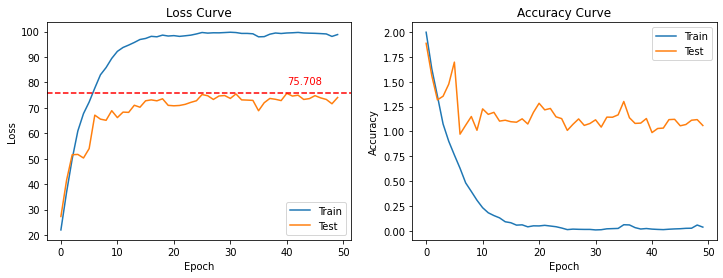

In [ ]:
draw_training_summary(filepath = 'target_train_DCA-BiLSTM.summary')

## Method 3: VGG (with bi-LSTM)

In [ ]:
#@title (Run) Part 5.3.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: VGG
#@markdown * Option 2: VGG-LSTM
#@markdown * Option 3: VGG-BiLSTM


method_name = 'VGG-BiLSTM'  #@param {type:"string"}
save_model_folder = './VGG-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'VGG-BiLSTM':
  # Model
  
  net = VGG('VGG11', enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'VGG-LSTM':
  # Model
  
  net = DLA('VGG11', enable_RNN='LSTM')
  net.cuda()
elif method_name == 'VGG':
  # Model
  
  net = DLA('VGG11', enable_RNN='None')
  net.cuda()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for VGG-BiLSTM
==> Training model from scratch..
Total trained parameters:  51242762


In [ ]:
#@title (Run) Part 5.3.2: Setup Target and Shadow datasets for DLA Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader = create_cifar_dataset_torch(batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_train_size, shadow_train_size = target_train_size, shadow_test_size= target_train_size)




==> Preparing dataset..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({0: 1538, 5: 1537, 9: 1533, 6: 1532, 3: 1504, 4: 1496, 2: 1487, 7: 1467, 1: 1459, 8: 1447})
Setting target_test_dataset size to  15000 Counter({3: 1557, 4: 1534, 8: 1521, 7: 1519, 1: 1511, 5: 1492, 2: 1484, 9: 1482, 0: 1455, 6: 1445})
Setting shadow_train_dataset size to  15000 Counter({1: 1542, 0: 1537, 8: 1523, 7: 1516, 2: 1515, 9: 1505, 5: 1503, 6: 1458, 4: 1456, 3: 1445})
Setting shadow_test_dataset size to  15000 Counter({6: 1565, 2: 1514, 4: 1514, 8: 1509, 7: 1498, 3: 1494, 1: 1488, 9: 1480, 0: 1470, 5: 1468})


In [ ]:
#@title (Run) Part 5.3.3: Start Target model training

max_epoch = 50  #@param {type:"integer"}
train_result_summary = 'target_train_VGG-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.303 | Train Acc: 9.375% (6/64)
30 234 Train Loss: 2.136 | Train Acc: 22.278% (442/1984)
60 234 Train Loss: 1.963 | Train Acc: 27.510% (1074/3904)
90 234 Train Loss: 1.852 | Train Acc: 31.370% (1827/5824)
120 234 Train Loss: 1.766 | Train Acc: 34.336% (2659/7744)
150 234 Train Loss: 1.691 | Train Acc: 37.159% (3591/9664)
180 234 Train Loss: 1.635 | Train Acc: 39.140% (4534/11584)
210 234 Train Loss: 1.586 | Train Acc: 41.269% (5573/13504)
234 Epoch: 0 | Train Loss: 1.552 | Train Acc: 42.581% (6377/14976)
0 234 Test Loss: 1.499 | Test Acc: 51.562% (33/64)
30 234 Test Loss: 1.701 | Test Acc: 42.742% (848/1984)
60 234 Test Loss: 1.707 | Test Acc: 41.957% (1638/3904)
90 234 Test Loss: 1.693 | Test Acc: 43.183% (2515/5824)
120 234 Test Loss: 1.694 | Test Acc: 43.673% (3382/7744)
150 234 Test Loss: 1.688 | Test Acc: 43.791% (4232/9664)
180 234 Test Loss: 1.686 | Test Acc: 43.931% (5089/11584)
210 234 Test Loss: 1.684 | Test Acc: 43.883% (5926/13504)
234 Epoch: 0 

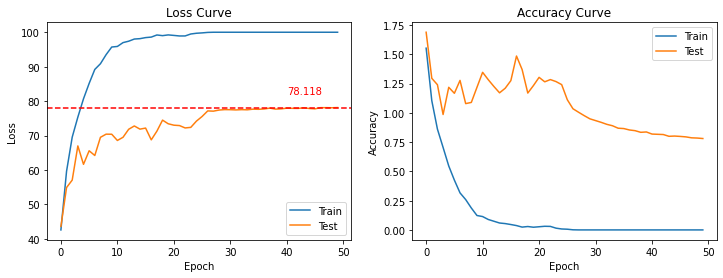

In [ ]:
draw_training_summary(filepath = 'target_train_VGG-BiLSTM.summary')

## Method 4: ResNet18 (with bi-LSTM)

In [ ]:
#@title (Run) Part 5.4.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: ResNet18
#@markdown * Option 2: ResNet18-LSTM
#@markdown * Option 3: ResNet18-BiLSTM


method_name = 'ResNet18-BiLSTM'  #@param {type:"string"}
save_model_folder = './ResNet18-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'ResNet18-BiLSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'ResNet18-LSTM':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='LSTM')
  net.cuda()
elif method_name == 'ResNet18':
  # Model
  net = ResNet(BasicBlock, [2, 2, 2, 2], enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for ResNet18-BiLSTM
==> Training model from scratch..
Total trained parameters:  53185610


In [ ]:
#@title (Run) Part 5.4.2: Setup Target and Shadow datasets for DLA Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader = create_cifar_dataset_torch(batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_train_size, shadow_train_size = target_train_size, shadow_test_size= target_train_size)




==> Preparing dataset..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({4: 1548, 1: 1543, 3: 1536, 5: 1519, 7: 1514, 6: 1513, 8: 1485, 2: 1451, 0: 1446, 9: 1445})
Setting target_test_dataset size to  15000 Counter({5: 1523, 9: 1522, 4: 1522, 0: 1509, 7: 1506, 2: 1503, 8: 1496, 6: 1487, 3: 1481, 1: 1451})
Setting shadow_train_dataset size to  15000 Counter({9: 1558, 8: 1551, 0: 1520, 2: 1515, 7: 1511, 3: 1499, 6: 1484, 4: 1458, 5: 1454, 1: 1450})
Setting shadow_test_dataset size to  15000 Counter({1: 1556, 2: 1531, 0: 1525, 6: 1516, 5: 1504, 3: 1484, 9: 1475, 4: 1472, 7: 1469, 8: 1468})


In [ ]:
#@title (Run) Part 5.4.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_ResNet18-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.301 | Train Acc: 14.062% (9/64)
30 234 Train Loss: 2.278 | Train Acc: 12.550% (249/1984)
60 234 Train Loss: 2.165 | Train Acc: 16.522% (645/3904)
90 234 Train Loss: 2.072 | Train Acc: 19.420% (1131/5824)
120 234 Train Loss: 1.988 | Train Acc: 22.766% (1763/7744)
150 234 Train Loss: 1.931 | Train Acc: 25.228% (2438/9664)
180 234 Train Loss: 1.885 | Train Acc: 26.778% (3102/11584)
210 234 Train Loss: 1.846 | Train Acc: 28.303% (3822/13504)
234 Epoch: 0 | Train Loss: 1.816 | Train Acc: 29.728% (4452/14976)
0 234 Test Loss: 1.735 | Test Acc: 35.938% (23/64)
30 234 Test Loss: 1.705 | Test Acc: 36.139% (717/1984)
60 234 Test Loss: 1.687 | Test Acc: 36.142% (1411/3904)
90 234 Test Loss: 1.679 | Test Acc: 36.762% (2141/5824)
120 234 Test Loss: 1.682 | Test Acc: 36.299% (2811/7744)
150 234 Test Loss: 1.680 | Test Acc: 36.362% (3514/9664)
180 234 Test Loss: 1.677 | Test Acc: 36.274% (4202/11584)
210 234 Test Loss: 1.675 | Test Acc: 36.411% (4917/13504)
234 Epoch: 0 

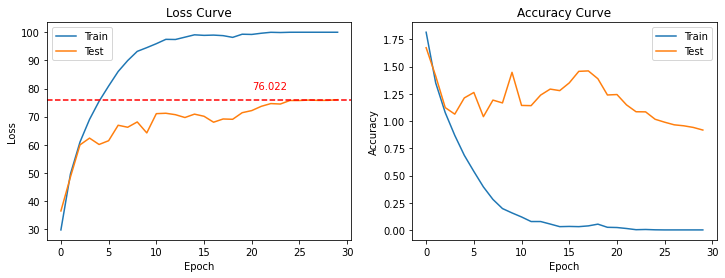

In [ ]:
draw_training_summary(filepath = 'target_train_ResNet18-BiLSTM.summary')

## Method 5: DenseNet (with bi-LSTM)

In [ ]:
#@title (Run) Part 5.5.1: Select an architecture for Target model training
#from torchsummary import summary


#@markdown Enter the folder of path to the pdb files:
#@markdown * Option 1: DenseNet121
#@markdown * Option 2: DenseNet121-LSTM
#@markdown * Option 3: DenseNet121-BiLSTM


method_name = 'DenseNet121-BiLSTM'  #@param {type:"string"}
save_model_folder = './DenseNet121-BiLSTM_models/'   #@param {type:"string"}
batch_size = 64  #@param {type:"integer"}
load_pretrain_weight = False   #@param {type:"boolean"}


print('==> Building model for ' + method_name)
if method_name == 'DenseNet121-BiLSTM':
  # Model
  net = DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, enable_RNN='Bi-LSTM')
  net.cuda()
elif method_name == 'DenseNet121-LSTM':
  # Model
  net = DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, enable_RNN='LSTM')
  net.cuda()
elif method_name == 'DenseNet121':
  # Model
  net = DenseNet(Bottleneck, [6,12,24,16], growth_rate=32, enable_RNN='None')
  net.cuda()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
  
if load_pretrain_weight:
  try:
      # Load checkpoint.
      print('==> Resuming from checkpoint..')
      checkpoint = torch.load(save_model_folder+'/ckpt.pth')
      net.load_state_dict(checkpoint['net'])
      best_acc = checkpoint['acc']
      start_epoch = checkpoint['epoch']
  except:
      print('!!! Error: no checkpoint directory found!')
else:
  print('==> Training model from scratch..')
  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total trained parameters: ",pytorch_total_params)


==> Building model for DenseNet121-BiLSTM
==> Training model from scratch..
Total trained parameters:  57351434


In [ ]:
#@title (Run) Part 5.4.2: Setup Target and Shadow datasets for DLA Training

target_train_size = 15000 #@param {type:"integer"}
target_test_size= 15000 #@param {type:"integer"}
shadow_train_size = 15000  #@param {type:"integer"} 
shadow_test_size= 15000 #@param {type:"integer"}

# create dataset for renet 
print('==> Preparing dataset..')
target_trainloader, target_testloader, shadow_train_dataset, shadow_testloader = create_cifar_dataset_torch(batch_size=batch_size, target_train_size = target_train_size, target_test_size= target_train_size, shadow_train_size = target_train_size, shadow_test_size= target_train_size)


==> Preparing dataset..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Setting target_train_dataset size to  15000 Counter({1: 1540, 5: 1510, 3: 1510, 4: 1507, 7: 1506, 0: 1504, 6: 1491, 2: 1484, 9: 1476, 8: 1472})
Setting target_test_dataset size to  15000 Counter({4: 1562, 8: 1555, 7: 1519, 2: 1509, 3: 1503, 9: 1492, 0: 1481, 5: 1476, 6: 1474, 1: 1429})
Setting shadow_train_dataset size to  15000 Counter({2: 1542, 5: 1527, 9: 1512, 6: 1505, 7: 1503, 3: 1503, 0: 1498, 8: 1489, 1: 1465, 4: 1456})
Setting shadow_test_dataset size to  15000 Counter({1: 1566, 6: 1530, 9: 1520, 0: 1517, 5: 1487, 3: 1484, 8: 1484, 4: 1475, 7: 1472, 2: 1465})


In [ ]:
#@title (Run) Part 5.4.3: Start Target model training

max_epoch = 30  #@param {type:"integer"}
train_result_summary = 'target_train_DenseNet121-BiLSTM.summary'   #@param {type:"string"}

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


if not load_pretrain_weight:
    f = open(train_result_summary, "w")
    f.write('')
    f.close()

for epoch in range(start_epoch, start_epoch+max_epoch):
    train(target_trainloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    test(target_testloader, epoch, batch_size=batch_size, logfile = train_result_summary)
    #scheduler.step()


Epoch: 0
0 234 Train Loss: 2.304 | Train Acc: 12.500% (8/64)
30 234 Train Loss: 2.264 | Train Acc: 15.222% (302/1984)
60 234 Train Loss: 2.172 | Train Acc: 19.621% (766/3904)
90 234 Train Loss: 2.080 | Train Acc: 21.909% (1276/5824)
120 234 Train Loss: 2.003 | Train Acc: 23.967% (1856/7744)
150 234 Train Loss: 1.946 | Train Acc: 26.159% (2528/9664)
180 234 Train Loss: 1.901 | Train Acc: 27.650% (3203/11584)
210 234 Train Loss: 1.859 | Train Acc: 29.088% (3928/13504)
234 Epoch: 0 | Train Loss: 1.827 | Train Acc: 30.442% (4559/14976)
0 234 Test Loss: 1.907 | Test Acc: 31.250% (20/64)
30 234 Test Loss: 1.893 | Test Acc: 32.863% (652/1984)
60 234 Test Loss: 1.899 | Test Acc: 32.659% (1275/3904)
90 234 Test Loss: 1.908 | Test Acc: 31.834% (1854/5824)
120 234 Test Loss: 1.917 | Test Acc: 32.038% (2481/7744)
150 234 Test Loss: 1.920 | Test Acc: 32.243% (3116/9664)
180 234 Test Loss: 1.922 | Test Acc: 32.269% (3738/11584)
210 234 Test Loss: 1.917 | Test Acc: 32.457% (4383/13504)
234 Epoch: 0 

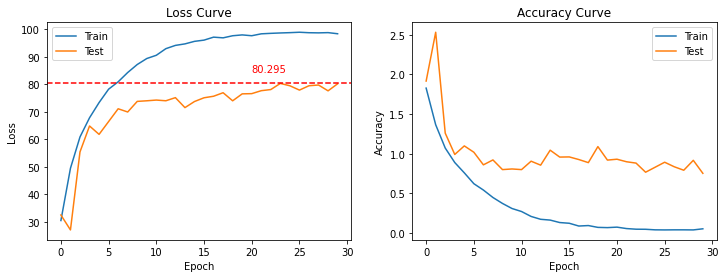

In [ ]:
draw_training_summary(filepath = 'target_train_DenseNet121-BiLSTM.summary')